## 1.0 Data Exploration

In [9]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re
import seaborn as sns
import string
from collections import Counter
from datetime import datetime
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from wordcloud import WordCloud

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\BELLA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\BELLA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### 1.1 Data Ingestion

In [33]:
# read data
data_dir = './../data/raw/tripadvisor_reviews.csv'
df = pd.read_csv(data_dir)
df.head()

,reviewer_rating,review_date,reviewer_category,text_review
0,5.0 of 5 bubbles,Written 27 May 2023,Couples,Visited the center early of May this year afte...
1,5.0 of 5 bubbles,Written 22 May 2023,Friends,I really enjoyed visiting the sepilok oranguta...
2,4.0 of 5 bubbles,Written 13 May 2023,Couples,It’s important to know that visiting the Sepil...
3,5.0 of 5 bubbles,Written 4 May 2023,Couples,We visited Sandakan to experience nature tour...
4,1.0 of 5 bubbles,Written 3 May 2023,NaN,Had a really disappointing visit here - it had...


In [34]:
df.shape

(3657, 4)

In [35]:
# checking data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3657 entries, 0 to 3656
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   reviewer_rating    3655 non-null   object
 1   review_date        3657 non-null   object
 2   reviewer_category  3166 non-null   object
 3   text_review        3657 non-null   object
dtypes: object(4)
memory usage: 114.4+ KB


In [36]:
# checking null values
df.isnull().sum()

reviewer_rating        2
review_date            0
reviewer_category    491
text_review            0
dtype: int64

### 1.2 Data & Text Cleaning

In [37]:
# Processing reviewer_rating column
# Change text to integer data

df['reviewer_rating'] = df['reviewer_rating'].str.extract(r'(\d+\.\d+)')
df['reviewer_rating'] = df['reviewer_rating'].astype(float)
df.dropna(subset=['reviewer_rating'], inplace=True)

In [38]:
# Transforming into date time data
df['review_date'] = df['review_date'].apply(lambda x: datetime.strptime(x, 'Written %d %B %Y').strftime('%d-%m-%Y'))

In [39]:
# Not going to remove NaN since it may contain valuable information
# Adjust the Nan value to a more appropriate name
df['reviewer_category'] = df['reviewer_category'].fillna('Not Specify')

In [40]:
# Creating a new column specifying the sentiment based on the reviewer_rating column
# 1-2 will be consider as negative (-1), 0 as neutral with a value (0) and 4-5 is positive (1)

def create_sentiment(rating):
    if rating==1 or rating==2:
        return -1 # negative sentiment
    elif rating==4 or rating==5:
        return 1 # positive sentiment
    else:
        return 0 # neutral sentiment

In [41]:
# apply the function to the df
df['reviewer_sentiment'] = df['reviewer_rating'].apply(create_sentiment)

In [42]:
# cleaning the text feature
def clean_text(text):
    # Lowercase the text
    text = text.lower()

    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))

    # Tokenization
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words("english"))
    tokens = [token for token in tokens if token not in stop_words]

    # Remove special characters and numbers
    tokens = [re.sub(r"[^a-zA-Z]", "", token) for token in tokens if token]

    # Join the tokens back into a single string
    cleaned_text = " ".join(tokens)

    return cleaned_text

In [43]:
# Apply the cleaning function to the entire column
df['cleaned_text_review'] = df['text_review'].apply(clean_text)
df = df.drop('text_review', axis=1)

### 1.3 Data Visualization

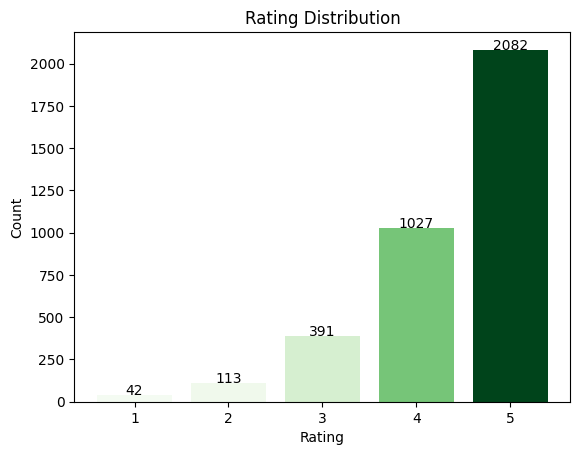

In [46]:
# Count the occurrences of each rating
rating_counts = {}
for rating in df.reviewer_rating:
    rating_counts[rating] = rating_counts.get(rating, 0) + 1

# Sort the ratings in ascending order
sorted_ratings = sorted(rating_counts.keys())

# Get the count and color density values
counts = [rating_counts[rating] for rating in sorted_ratings]
max_count = max(counts)
colors = [plt.cm.Greens(count / max_count) for count in counts]

# Plot the rating distribution
plt.bar(sorted_ratings, counts, color=colors)

# Add data labels
for rating, count in zip(sorted_ratings, counts):
    plt.text(rating, count + 0.5, str(count), ha='center')

# Set plot title and axis labels
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')

# Show the plot
plt.show()

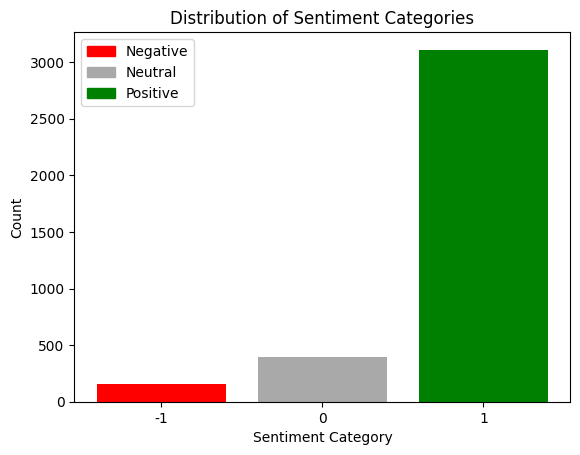

In [47]:
# Visualizing the sentiment distribution
# Count the number of samples for each category
category_counts = df['reviewer_sentiment'].value_counts()

# Define the colors for each category
colors = {-1: 'red', 0: 'darkgrey', 1: 'green'}

# Create the bar plot
plt.bar(category_counts.index, category_counts.values, color=[colors[x] for x in category_counts.index])

# Set plot labels and title
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.title('Distribution of Sentiment Categories')

# Set custom tick labels
plt.xticks(list(colors.keys()), [str(x) for x in colors.keys()])

# Create a colorbar
colors_legend = [plt.Rectangle((0, 0), 1, 1, color=color) for color in colors.values()]
labels_legend = ['Negative', 'Neutral', 'Positive']
plt.legend(colors_legend, labels_legend)

plt.show()

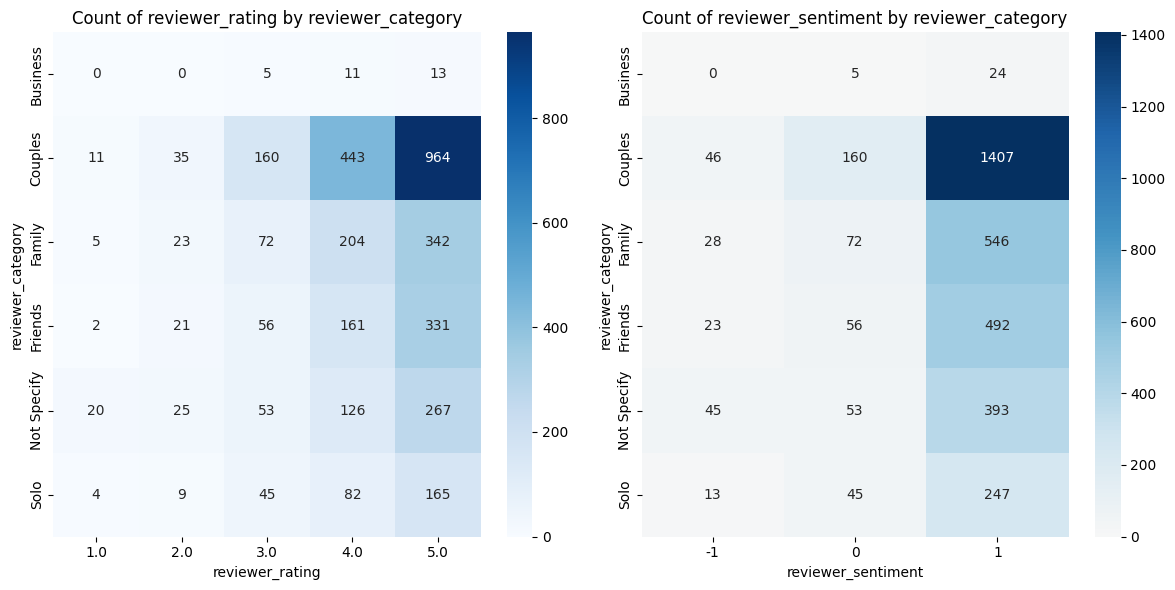

In [48]:
# Group by reviewer_category and count the occurrences of each reviewer_rating
rating_counts = df.groupby('reviewer_category')['reviewer_rating'].value_counts().unstack().fillna(0)

# Plot the first chart: reviewer_rating grouped by reviewer_category
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.heatmap(rating_counts, annot=True, cmap='Blues', fmt='g')
plt.title('Count of reviewer_rating by reviewer_category')
plt.xlabel('reviewer_rating')
plt.ylabel('reviewer_category')

# Group by reviewer_category and count the occurrences of each reviewer_sentiment
sentiment_counts = df.groupby('reviewer_category')['reviewer_sentiment'].value_counts().unstack().fillna(0)

# Plot the second chart: reviewer_sentiment grouped by reviewer_category
plt.subplot(1, 2, 2)
sns.heatmap(sentiment_counts, annot=True, cmap='RdBu', center=0, fmt='g')
plt.title('Count of reviewer_sentiment by reviewer_category')
plt.xlabel('reviewer_sentiment')
plt.ylabel('reviewer_category')

plt.tight_layout()
plt.show()

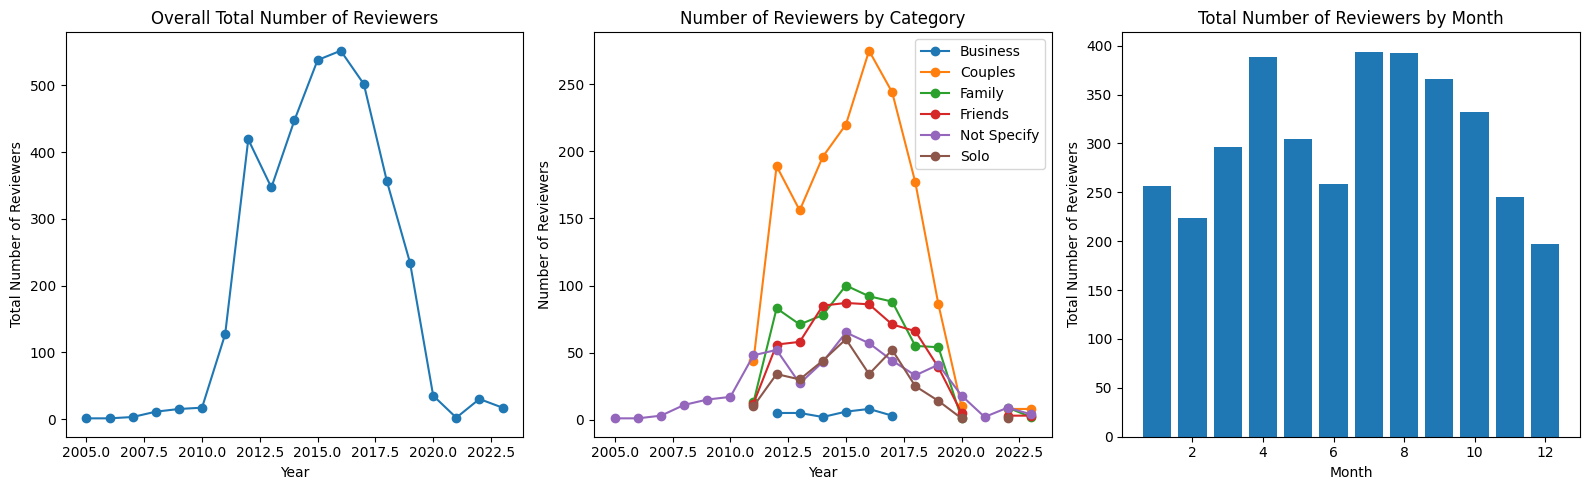

In [49]:
# Convert "review_date" column to datetime
df['review_date'] = pd.to_datetime(df['review_date'], format='%d-%m-%Y')

# Extract the year and month from "review_date" column
df['review_year'] = df['review_date'].dt.year
df['review_month'] = df['review_date'].dt.month

# Group by year and reviewer category and count the number of reviewers
reviewer_counts = df.groupby(['review_year', 'reviewer_category']).size().unstack()
overall_total = df.groupby('review_year').size()

# Group by month and count the total number of reviewers
reviewer_counts_month = df.groupby('review_month').size()

# Create a figure with three subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 5))

# Plot the overall total category
axes[0].plot(overall_total.index, overall_total.values, marker='o')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Total Number of Reviewers')
axes[0].set_title('Overall Total Number of Reviewers')

# Plot each category by year
for category in reviewer_counts.columns:
    axes[1].plot(reviewer_counts.index, reviewer_counts[category], marker='o', label=category)

axes[1].set_xlabel('Year')
axes[1].set_ylabel('Number of Reviewers')
axes[1].set_title('Number of Reviewers by Category')
axes[1].legend()

# Plot the total number of reviewers by month (as a bar plot)
axes[2].bar(reviewer_counts_month.index, reviewer_counts_month.values)
axes[2].set_xlabel('Month')
axes[2].set_ylabel('Total Number of Reviewers')
axes[2].set_title('Total Number of Reviewers by Month')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

### 1.4 Text Visualization

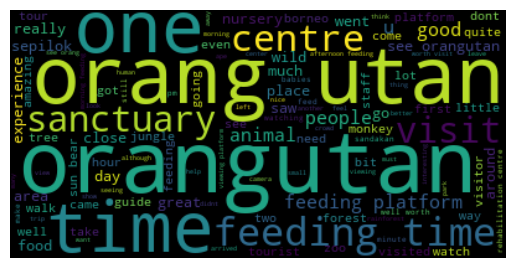

In [50]:
# A quick visualisation on the text review
# Concatenate all the text from the text column into a single string
text = " ".join(review for review in df["cleaned_text_review"])

# Generate the word cloud
wordcloud = WordCloud().generate(text)

# Create the plot and display the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

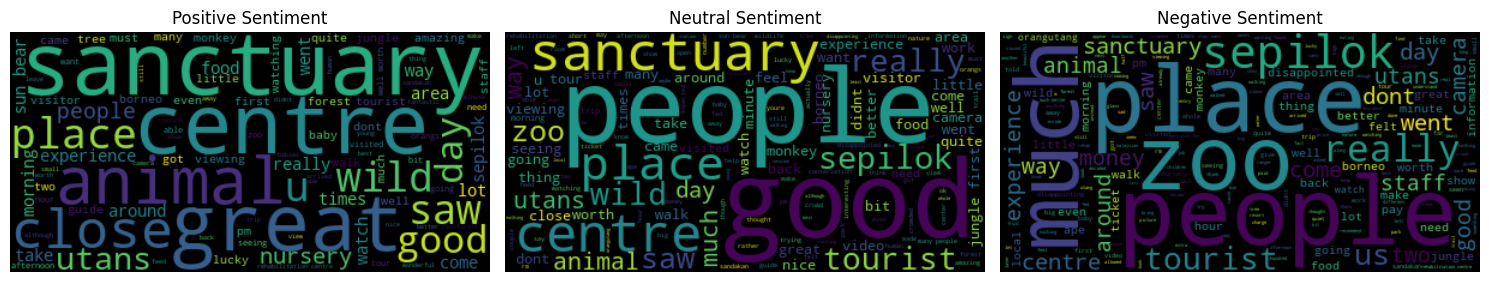

In [52]:
# Filter the text data based on sentiment categories
positive_text = " ".join(review for review in df[df["reviewer_sentiment"] == 1]["cleaned_text_review"])
neutral_text = " ".join(review for review in df[df["reviewer_sentiment"] == 0]["cleaned_text_review"])
negative_text = " ".join(review for review in df[df["reviewer_sentiment"] == -1]["cleaned_text_review"])

# Define the words to be removed
words_to_remove = ["orangutan", "orang", "utan", 'one', 'orangutans', 'see','go','time', 'visit','feeding','platform']

# Remove specific words from each sentiment category
for word in words_to_remove:
    positive_text = re.sub(r'\b' + re.escape(word) + r'\b', '', positive_text)
    neutral_text = re.sub(r'\b' + re.escape(word) + r'\b', '', neutral_text)
    negative_text = re.sub(r'\b' + re.escape(word) + r'\b', '', negative_text)

# Generate word clouds for each sentiment category
positive_wordcloud = WordCloud().generate(positive_text)
neutral_wordcloud = WordCloud().generate(neutral_text)
negative_wordcloud = WordCloud().generate(negative_text)

# Create subplots for each word cloud
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Display the positive word cloud
axes[0].imshow(positive_wordcloud, interpolation='bilinear')
axes[0].set_title('Positive Sentiment')
axes[0].axis("off")

# Display the neutral word cloud
axes[1].imshow(neutral_wordcloud, interpolation='bilinear')
axes[1].set_title('Neutral Sentiment')
axes[1].axis("off")

# Display the negative word cloud
axes[2].imshow(negative_wordcloud, interpolation='bilinear')
axes[2].set_title('Negative Sentiment')
axes[2].axis("off")

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

### 1.5 Save processed dataset

In [53]:
save_dir = './../data/processed/processed_data.csv'
df.to_csv(save_dir, index=False)